# Tuning of Loan Interest Rate Prediction Model

First, all the necessary libraries are imported.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
import lightgbm as lgbm
import optuna
from optuna import Trial
import joblib
from helper_functions.ml_data_prep import (
    X_y_spilt,
    stratified_sample,
)
from sklearn.feature_selection import SelectFromModel

Data is loaded and appropriately splited. 

In [3]:
drop_cols = ["sub_grade", "sub_grade_enc", "grade_enc"]
# Subsample training and validation if wanting to check the code
# X_train, y_train = (
#     pd.read_pickle("./data/data_train_mod2.pkl")
#     .pipe(stratified_sample, frac=0.1, col="sub_grade")
#     .drop(columns=drop_cols)
#     .pipe(X_y_spilt, target="int_rate")
# )
# X_val, y_val = (
#     pd.read_pickle("./data/data_val_mod2.pkl")
#     .pipe(stratified_sample, frac=0.1, col="sub_grade")
#     .drop(columns=drop_cols)
#     .pipe(X_y_spilt, target="int_rate")
# )
X_train, y_train = (
    pd.read_pickle("./data/data_train_mod2.pkl")
    .drop(columns=drop_cols)
    .pipe(X_y_spilt, target="int_rate")
)
X_val, y_val = (
    pd.read_pickle("./data/data_val_mod2.pkl")
    .drop(columns=drop_cols)
    .pipe(X_y_spilt, target="int_rate")
)
print(f"Number of training instances {X_train.shape[0]}")
print(f"Number of validation instances {X_val.shape[0]}")
X_train.dtypes

Number of training instances 1765426
Number of validation instances 238636


loan_amnt                  float64
term                      category
grade                     category
home_ownership            category
verification_status       category
purpose                   category
dti                        float64
inq_last_6mths             float64
mths_since_last_record     float64
application_type          category
open_il_12m                float64
all_util                   float64
total_rev_hi_lim           float64
inq_last_12m               float64
acc_open_past_24mths       float64
bc_open_to_buy             float64
bc_util                    float64
mo_sin_old_il_acct         float64
mo_sin_old_rev_tl_op       float64
mort_acc                   float64
mths_since_recent_inq      float64
num_actv_rev_tl            float64
num_tl_op_past_12m         float64
pct_tl_nvr_dlq             float64
tot_hi_cred_lim            float64
fico                       float64
dtype: object

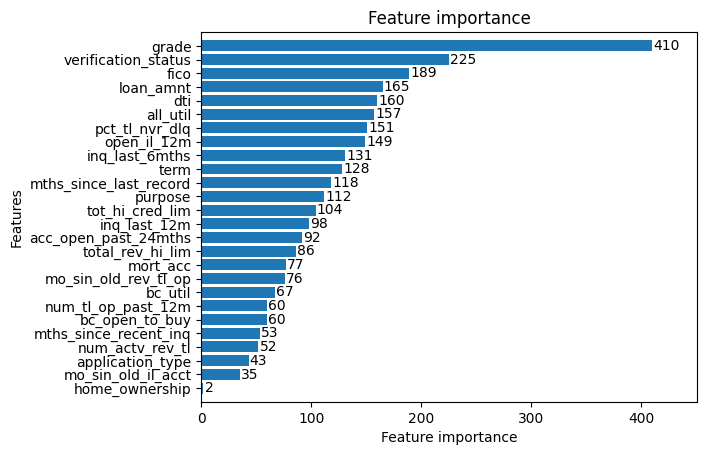

In [3]:
selector_model = LGBMRegressor(verbose=-1, random_state=42)
selector_model.fit(X_train, y_train)
lgbm.plot_importance(selector_model, height=0.8, grid=False, ignore_zero=False)
plt.title("Feature Importance for Loan Interest Rate Prediction Model")
plt.show()

Necessary subfunctions for Optuna objective function defined.

In [4]:
def instantiate_feature_selector(trial: Trial) -> SelectFromModel:
    params = {
        "threshold": -np.inf,
        "prefit": True,
        "max_features": trial.suggest_int("max_features", 5, 25),
    }
    feature_selector = SelectFromModel(selector_model, **params).set_output(
        transform="pandas"
    )
    return feature_selector


def instantiate_lightgbm(trial: Trial) -> LGBMRegressor:
    params = {
        "verbosity": -1,
        "n_jobs": 4,
        "random_state": 42,
        "n_estimators": 500,
        "objective": "regression",
        "boosting_type": "gbdt",
        "metric": "rmse",
        "early_stopping_rounds": 10,
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0, step=0.1),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.4, 1.0, step=0.1
        ),
        "max_depth": trial.suggest_int("max_depth", 5, 63),
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 0.01, 1000
        ),
        "num_leaves": trial.suggest_int("num_leaves", 7, 31),
    }
    return LGBMRegressor(**params)


def instantiate_model(trial: Trial) -> Pipeline:
    pipeline = Pipeline([
        ("selector", instantiate_feature_selector(trial)),
        ("estimator", instantiate_lightgbm(trial)),
    ])
    return pipeline

Optuna study defined and run.

In [5]:
def objective(trial: Trial) -> float:
    model = instantiate_model(trial)
    prepro = model[:-1].fit(X_train)
    X_val_prepro = prepro.transform(X_val)
    pruning_callback = optuna.integration.LightGBMPruningCallback(
        trial, "rmse"
    )
    model.fit(
        X_train,
        y_train,
        estimator__eval_set=[(X_val_prepro, y_val)],
        estimator__eval_metric=["rmse"],
        estimator__callbacks=[pruning_callback],
    )
    trial.set_user_attr("n_estimators", model[-1].best_iteration_ + 1)
    y_pred = model.predict(X_val)
    value = mean_squared_error(y_val, y_pred, squared=False)
    return value


pruner = optuna.pruners.MedianPruner(n_warmup_steps=10, n_min_trials=5)
study = optuna.create_study(
    study_name="rate_model_hypertune",
    storage="sqlite:///rate_model_hypertune.db",
    load_if_exists=True,
    pruner=pruner,
    direction="minimize",
)
study.optimize(objective, n_trials=100)
best_trial = study.best_trial
n_estimators = best_trial.user_attrs["n_estimators"]
print("Best RMSE value:", study.best_value)
print("Best parameters:")
display(study.best_params)

[I 2024-02-04 13:54:00,451] A new study created in RDB with name: rate_model_hypertune
[I 2024-02-04 13:54:21,175] Trial 0 finished with value: 1.217365492683584 and parameters: {'max_features': 8, 'reg_lambda': 0.4330139514619353, 'reg_alpha': 4.195616144962272, 'subsample': 0.9, 'colsample_bytree': 0.5, 'max_depth': 28, 'min_child_weight': 417.49222169627393, 'num_leaves': 13}. Best is trial 0 with value: 1.217365492683584.
[I 2024-02-04 13:54:39,382] Trial 1 finished with value: 1.1918494481971722 and parameters: {'max_features': 18, 'reg_lambda': 3.4523306201778485, 'reg_alpha': 0.11235434151571004, 'subsample': 0.9, 'colsample_bytree': 0.7000000000000001, 'max_depth': 18, 'min_child_weight': 123.0122649360983, 'num_leaves': 29}. Best is trial 1 with value: 1.1918494481971722.
[I 2024-02-04 13:54:56,157] Trial 2 finished with value: 1.1975075806096795 and parameters: {'max_features': 20, 'reg_lambda': 0.0002474315065281649, 'reg_alpha': 0.014886977189524293, 'subsample': 0.4, 'cols

Best RMSE value: 1.1859349736154021
Best parameters:


{'max_features': 24,
 'reg_lambda': 0.00012150145206575937,
 'reg_alpha': 0.0014653150149294624,
 'subsample': 0.9,
 'colsample_bytree': 1.0,
 'max_depth': 25,
 'min_child_weight': 480.1075614827911,
 'num_leaves': 22}

The final tuned model obtained.

In [6]:
rate_model = instantiate_model(best_trial)
rate_model.set_params(
    estimator__n_estimators=n_estimators,
    estimator__early_stopping_rounds=None,
    estimator__callbacks=None,
)
rate_model

Pipeline(steps=[('selector',
                 SelectFromModel(estimator=LGBMRegressor(random_state=42,
                                                         verbose=-1),
                                 max_features=24, prefit=True,
                                 threshold=-inf)),
                ('estimator',
                 LGBMRegressor(callbacks=None, early_stopping_rounds=None,
                               max_depth=25, metric='rmse',
                               min_child_weight=480.1075614827911,
                               n_estimators=320, n_jobs=4, num_leaves=22,
                               objective='regression', random_state=42,
                               reg_alpha=0.0014653150149294624,
                               reg_lambda=0.00012150145206575937, subsample=0.9,
                               verbosity=-1))])

Model fitted to the whole training data (training and validation sets) and dumped for later use.

In [4]:
X_train, y_train = (
    pd.concat([
        pd.read_pickle("./data/data_train_mod2.pkl"),
        pd.read_pickle("./data/data_val_mod2.pkl"),
    ])
    .drop(columns=drop_cols)
    .pipe(X_y_spilt, target="int_rate")
)
rate_model.fit(X_train, y_train)
joblib.dump(rate_model, "./tuned_models/rate_model.joblib")

['./tuned_models/rate_model.joblib']